# Toy Models of Superposition

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/tms.ipynb)

Let's run through an example using Anthropic's toy models of superposition. 

This example is mostly to test that our SGLD estimator is working as expected and to figure out how to integrate this in an SGD setting.

Credits: Edmund Lau. Chen et al. (Upcoming)

In [ ]:
%pip install devinterp matplotlib scipy

In [46]:
import os
from typing import Iterable, Optional

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from devinterp.zoo.tms import ToyAutoencoder, SyntheticBinaryValued

DEVICE = "mps" # "cpu"
# os.environ.get(
#     "DEVICE",
#     "cuda:0"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu",
# )
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))

In [47]:
import random

def generate_2d_kgon_vertices(k, rot=0., pad_to=None, force_length=0.9):
    # Angles for the vertices
    theta = np.linspace(0, 2*np.pi, k, endpoint=False) + rot

    # Generate the vertices
    x = np.cos(theta)
    y = np.sin(theta)
    result = np.vstack((x, y))

    if pad_to is not None and k < pad_to:
        num_pad = pad_to - k
        result = np.hstack([result, np.zeros((2, num_pad))])
        
    return (result * force_length)

# plot_polygons([generate_2d_ngon_vertices(4, rot=0.).T, generate_2d_ngon_vertices(4, rot=np.pi/3).T])


def generate_init_param(m, n, init_kgon, prior_std=1., no_bias=True, init_zerobias=True, seed=0, force_negb=False, noise=0.01):
    np.random.seed(seed)
    
    if init_kgon is None or m != 2:
        init_W = np.random.normal(size=(m, n)) * prior_std
    else:
        assert init_kgon <= n
        rand_angle = np.random.uniform(0, 2 * np.pi, size=(1,))
        noise = np.random.normal(size=(m, n)) * noise
        init_W = generate_2d_kgon_vertices(init_kgon, rot=rand_angle, pad_to=n) + noise
    
    if no_bias:
        param = {"W": init_W}
    else:
        init_b = np.random.normal(size=(n, 1)) * prior_std
        if force_negb:
            init_b = -np.abs(init_b)
        if init_zerobias:
            init_b = init_b * 0
        param = {
            "W": init_W, 
            "b": init_b
        }
    return param

In [48]:
from copy import deepcopy


def create_and_train(
    m: int,
    n: int,
    num_samples: int,
    batch_size: Optional[int] = 1,
    num_epochs: int = 100,
    lr: float = 0.001,
    log_ivl: Iterable[int] = [],
    device=DEVICE,
    momentum=0.9,
    weight_decay=0.0,
    init_kgon=None,
    no_bias=False,
    init_zerobias=False,
    prior_std=10.,
    seed=0
):
    model = ToyAutoencoder(m, n, final_bias=True)

    init_weights = generate_init_param(n, m, init_kgon, no_bias=no_bias, init_zerobias=init_zerobias, prior_std=prior_std, seed=seed)
    model.embedding.weight.data = torch.from_numpy(init_weights["W"]).float()
    
    if "b" in init_weights:
        model.unembedding.bias.data = torch.from_numpy(init_weights["b"].flatten()).float()

    dataset = SyntheticBinaryValued(num_samples, m, 1)
    batch_size = batch_size

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    logs = pd.DataFrame([{"loss": None, "acc": None, "step": step} for step in log_ivl])

    model.to(device)
    weights = []

    def log(step):
        loss = 0.0
        acc = 0.0
        length = 0

        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(device)
                outputs = model(batch)
                loss += criterion(outputs, batch).item()
                acc += (outputs.round() == batch).float().sum().item()
                length += len(batch)

        loss /= length
        acc /= length

        logs.loc[logs["step"] == step, ["loss", "acc"]] = [loss, acc]
        weights.append({k: v.cpu().detach().clone().numpy() for k, v in model.state_dict().items()})

    step = 0
    log(step)

    for epoch in tqdm(range(num_epochs), desc="Training"):
        for batch in dataloader:
            batch = batch.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch)
            loss = criterion(outputs, batch)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            step += 1

            if step in log_ivl:
                log(step)

    return logs, weights

In [4]:
def plot_polygon(
    W: torch.Tensor,
    b=None,
    ax=None,
    ax_bias=None,
    ax_wnorm=None,
    hull_alpha=0.3,
    dW=None,
    dW_scale=0.3,
    orderb=True,
):
    """Credits: Edmund Lau"""
    if ax is None:
        if W.shape[0] == 2:
            fig, ax = plt.subplots(1, 1)
        elif W.shape[0] == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")

    if W.shape[0] == 2:  # 2D case
        # Compute the norms of the columns
        norms = np.linalg.norm(W, axis=0)

        # Normalize a copy of the vectors for angle calculations
        W_normalized = W / norms

        # Compute angles from the x-axis for each vector
        angles = np.arctan2(W_normalized[1, :], W_normalized[0, :])

        # Sort the columns of W by angles
        order = np.argsort(angles)
        W_sorted = W[:, order]

        # Plot the origin
        ax.scatter(0, 0, color="red")

        # Plot the vectors
        for i in range(W_sorted.shape[1]):
            ax.quiver(
                0,
                0,
                W_sorted[0, i],
                W_sorted[1, i],
                angles="xy",
                scale_units="xy",
                scale=1,
                width=0.003,
            )
        if dW is not None:
            dW = -dW_scale * dW / np.max(np.linalg.norm(dW, axis=0))
            for col in range(W.shape[1]):
                ax.quiver(
                    W[0, col],
                    W[1, col],
                    dW[0, col],
                    dW[1, col],
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    color="r",
                    width=0.005,
                )

        # Connect the vectors to form a polygon
        polygon = np.column_stack((W_sorted, W_sorted[:, 0]))
        ax.plot(polygon[0, :], polygon[1, :], alpha=0.5)

        # Plot the convex hull
        hull = ConvexHull(W.T)
        vs = list(hull.vertices) + [hull.vertices[0]]
        ax.plot(W[0, vs], W[1, vs], "r--", alpha=hull_alpha)

        # Set the aspect ratio of the plot to equal to ensure that angles are displayed correctly
        ax.set_aspect("equal", adjustable="box")

    elif W.shape[0] == 3:  # 3D case
        # Plot the origin
        ax.scatter([0], [0], [0], color="red")

        # Plot the vectors
        for i in range(W.shape[1]):
            ax.plot([0, W[0, i]], [0, W[1, i]], [0, W[2, i]], "b-")

        # Plot the convex hull
        hull = ConvexHull(W.T)
        for s in hull.simplices:
            s = np.append(s, s[0])  # Here we cycle back to the first coordinate
            ax.plot(W[0, s], W[1, s], W[2, s], "r--", alpha=hull_alpha)
    else:
        raise ValueError("W must have either 2 or 3 rows")

    if b is not None and ax_bias is not None:
        b_plot = np.ravel(b)
        if orderb:
            b_plot = b_plot[order]
        bar_colors = ["r" if val < 0 else "b" for val in b_plot]
        yticks = np.array(range(1, len(b_plot) + 1))
        ax_bias.barh(
            yticks - 0.4,
            np.abs(b_plot),
            height=0.4,
            color=bar_colors,
            align="edge",
        )
        ax_bias.set_yticks(yticks)
        ax_bias.yaxis.tick_right()
        ax_bias.tick_params(axis="y", labelsize="x-small")
        ax_bias.tick_params(axis="x", labelsize="x-small")

    if ax_wnorm is not None:
        yticks = np.array(range(1, W.shape[1] + 1))
        wnorms = np.linalg.norm(W, axis=0)
        if orderb:
            wnorms = wnorms[order]
        ax_wnorm.barh(yticks, width=wnorms, height=0.4, color="black", alpha=0.9, align="edge")
    return ax


def plot_polygons(Ws):
    fig, axes = plt.subplots(1, len(Ws), figsize=(15, 4))

    for ax, W in zip(axes, Ws):
        plot_polygon(W, ax=ax)

Training: 100%|██████████| 5000/5000 [02:11<00:00, 38.05it/s]


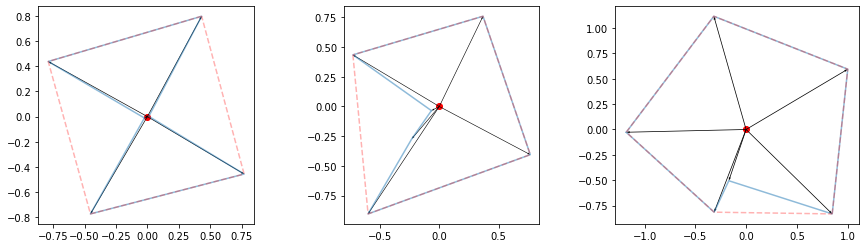

<Axes: xlabel='step'>

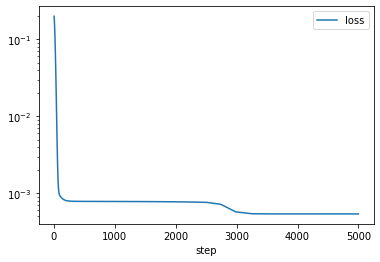

In [56]:
NUM_FEATURES = 6
NUM_HIDDEN_UNITS = 2
NUM_SAMPLES = 1000  
NUM_EPOCHS = 5000

torch.manual_seed(1)
log_ivl = np.logspace(0, np.log10(NUM_EPOCHS), 100).astype(int)
logs, weights = create_and_train(NUM_FEATURES, NUM_HIDDEN_UNITS, num_samples=NUM_SAMPLES, log_ivl=log_ivl, batch_size=100, lr=0.01, num_epochs=NUM_EPOCHS, init_kgon=4, init_zerobias=False, seed=1)

weights_to_plot = [weights[0]['embedding.weight'], weights[len(weights) // 2]['embedding.weight'], weights[-1]['embedding.weight']]
plot_polygons(weights_to_plot)
plt.show()

logs.plot(x="step", y="loss", logx=True)

<Axes: xlabel='step'>

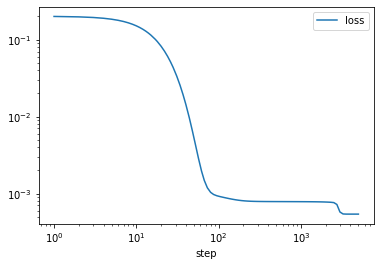

In [58]:
logs.plot(x="step", y="loss", logx=True, logy=True)

In [60]:
import yaml
from devinterp.slt.cov import BetweenLayerCovarianceAccumulator, CovarianceAccumulator
from devinterp.slt.llc import estimate_learning_coeff_with_summary
from torch.nn import functional as F
from devinterp.optim.sgld import SGLD
from torch.utils.data import TensorDataset


model = ToyAutoencoder(NUM_FEATURES, NUM_HIDDEN_UNITS, final_bias=True)
dataset = SyntheticBinaryValued(NUM_SAMPLES, NUM_FEATURES, 1)
dataset_double = TensorDataset(dataset.data, dataset.data)
loader = DataLoader(dataset_double, batch_size=1000, shuffle=True)

lcs = []
steps = logs.step.values

accessors = {
    "weight": lambda model: model.embedding.weight,
    "bias": lambda model: model.unembedding.bias,
}

pairs = {
    "weights": ("weight", "weight"),
    "bias": ("bias", "bias"),
    # "weight_bias": ("weight", "bias"),
}

params = {k: v(model).view((-1,)) for k, v in accessors.items()}
print({k: p.shape for k, p in params.items()})
num_weights = len(torch.cat(list(params.values())))

callbacks = [
    CovarianceAccumulator(num_weights, list(accessors.values()), device=DEVICE),
    BetweenLayerCovarianceAccumulator(model, pairs, device=DEVICE, **accessors)
]

for step, state_dict in tqdm(zip(steps, weights), total=len(steps)):
    model.load_state_dict({k: torch.Tensor(v) for k, v in state_dict.items()})
    
    lcs.append({
        "step": step,
        **estimate_learning_coeff_with_summary(
            model,
            loader,
            F.mse_loss,
            device=DEVICE,
            sampling_method=SGLD,
            optimizer_kwargs={
                "lr": 1e-3,
                "num_samples": NUM_SAMPLES,
                "elasticity": 1.
            },
            verbose=False,
            num_draws=500,
            num_chains=5,
            callbacks=callbacks
    )})

    for callback in callbacks:
        callback.reset()
    
    def clean(v):
        if isinstance(v, torch.Tensor):
            return v.cpu().detach().clone().numpy().tolist()
        elif isinstance(v, np.ndarray):
            return v.tolist()
        elif isinstance(v, dict):
            return {k: clean(v) for k, v in v.items()}
        elif isinstance(v, list):
            return [clean(v) for v in v]
        else:
            return v

    preview = {k: clean(v) for k, v in lcs[-1].items()}
    del preview["matrix"]
    del preview["eigvecs"]
    del preview["loss/trace"]
    del preview["weights"]["matrix"]
    del preview["weights"]["eigvecs"]
    del preview["bias"]["matrix"]
    del preview["bias"]["eigvecs"]
    preview["step"] = int(step)
    # print(yaml.dump(preview, default_flow_style=False))

{'weight': torch.Size([12]), 'bias': torch.Size([6])}


  0%|          | 0/100 [00:00<?, ?it/s]

 83%|████████▎ | 83/100 [17:20<03:33, 12.54s/it]


: 

Text(0.5, 0, 'Step')

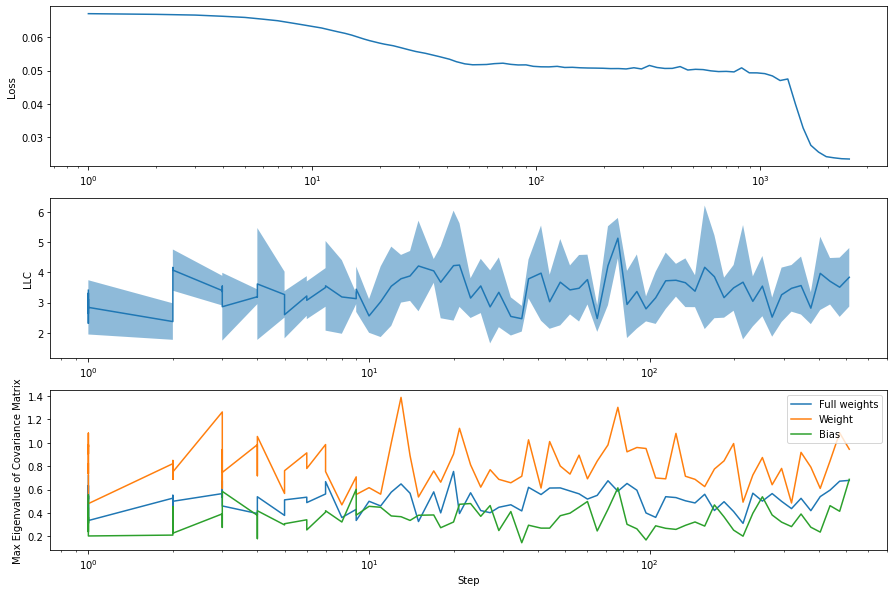

In [45]:
lc_df = pd.DataFrame(lcs)

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

axes[0].plot(steps, logs["loss"])
axes[0].set_ylabel("Loss")
axes[0].set_yscale("log")
axes[1].plot(steps[:80], lc_df["llc/mean"])
axes[1].fill_between(steps[:80], lc_df["llc/mean"] - lc_df["llc/std"], lc_df["llc/mean"] + lc_df["llc/std"], alpha=0.5)
axes[1].set_ylabel("LLC")
axes[2].plot(steps[:80], [eigvals[0] for eigvals in lc_df["eigvals"]], label="Full weights")
axes[2].plot(steps[:80], [eigvals["eigvals"][0] for eigvals in lc_df["weights"]], label="Weight")
axes[2].plot(steps[:80], [eigvals["eigvals"][0] for eigvals in lc_df["bias"]], label="Bias")
axes[2].legend()
axes[2].set_ylabel("Max Eigenvalue of Covariance Matrix")

for ax in axes:
    ax.set_xscale("log")

axes[2].set_xlabel("Step")